In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.10.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.10.2 on the current Colab Runtime...
2024-04-11 19:47:55 URL:https://julialang-s3.julialang.org/bin/linux/x64/1.10/julia-1.10.2-linux-x86_64.tar.gz [169654402/169654402] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.10

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [1]:
versioninfo()

Julia Version 1.10.2
Commit bd47eca2c8 (2024-03-01 10:14 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 6 × AMD Ryzen 5 4500U with Radeon Graphics         
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, znver2)
Threads: 1 default, 0 interactive, 1 GC (on 6 virtual cores)
Environment:
  JULIA_NUM_THREADS = 


In [1]:
import Pkg
Pkg.add("SDDP")
Pkg.add("HiGHS")
Pkg.add("Plots")

    Updating registry at `C:\Users\matsz\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Manifest.toml`


In [2]:
using SDDP, HiGHS, Statistics, DataFrames, Plots, XLSX

In [3]:
exp.([-0.14, 0.06, 0.26])

3-element Vector{Float64}:
 0.8693582353988059
 1.0618365465453596
 1.2969300866657718

In [4]:
function asset_management_simple()

    
    model = SDDP.PolicyGraph(
        SDDP.MarkovianGraph(
            Array{Float64,2}[
                [1.0]',
                [0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],                                             
            ],
        ),
        lower_bound = -1_800.0,
        optimizer = HiGHS.Optimizer,
    ) do subproblem, index
        (stage, markov_state) = index
        r_stock = [0.867, 1.06, 1.297]
        r_bonds = [1.03]
        consumption = 5
        goal = 50

        @variable(subproblem, stocks >= 0, SDDP.State, initial_value = 0.0)
        @variable(subproblem, bonds >= 0, SDDP.State, initial_value = 0.0)

        
        if stage == 1
            @constraint(subproblem, stocks.out + bonds.out + consumption == 55)
            @stageobjective(subproblem, 0)
        elseif 1 < stage < 6
            @constraint(
                subproblem,
                r_stock[markov_state] * stocks.in +
                r_bonds[1] * bonds.in == stocks.out + bonds.out + consumption
            )
            @stageobjective(subproblem, 0)
        else
            @variable(subproblem, over >= 0)
            @variable(subproblem, short >= 0)
            @constraint(
                subproblem,
                r_stock[markov_state] * stocks.in +
                r_bonds[1] * bonds.in - over + short + consumption == goal
            )
            @stageobjective(subproblem, -over + 4 * short)
        end
    end
    SDDP.train(model;log_frequency = 5)
   #@test SDDP.calculate_bound(model) ≈ 1.514 atol = 1e-4
    return model
end

model = asset_management_simple()

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 16
  state variables : 2
  scenarios       : 2.43000e+02
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [5, 7]
  AffExpr in MOI.EqualTo{Float64}         : [1, 1]
  VariableRef in MOI.GreaterThan{Float64} : [3, 5]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [9e-01, 1e+00]
  objective range  [1e+00, 4e+00]
  bounds range     [2e+03, 2e+03]
  rhs range        [5e+00, 5e+01]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
----------------------------------------------

A policy graph with 16 nodes.
 Node indices: (1, 1), ..., (6, 3)


In [18]:
function asset_management_merton_deterministic()
    
    #goal = 65
    #-(consumption^-1-1)/-1

    model = SDDP.PolicyGraph(
        SDDP.MarkovianGraph(
            Array{Float64,2}[
                [1.0]',
                [0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],                                
            ],
        ),
        lower_bound = -200.0,
        optimizer = HiGHS.Optimizer,
    ) do subproblem, index
        (stage, markov_state) = index
        r_stock_deterministic = [1, 1.06, 0.866, 1.254,1.06,1.06]
        r_bonds = [1.03]
        @variable(subproblem, stocks >= 0, SDDP.State, initial_value = 0.0)
        @variable(subproblem, bonds >= 0, SDDP.State, initial_value = 0.0)
       # @variable(subproblem, consumption >= 0)

        minimum_limit = 0
        acceptable_limit = 20
        desired_limit = 25

        @variable(subproblem, 0 <= acceptable <= acceptable_limit)
        @variable(subproblem, 0 <= desired <= desired_limit - acceptable_limit)
        @variable(subproblem, 0 <= above_desired)
       # @constraint(subproblem, acceptable + desired + above_desired == consumption)

        if stage == 1
            @constraint(subproblem, stocks.out + bonds.out + acceptable + desired + above_desired == 100)            
            @stageobjective(subproblem, -(3*acceptable + 2*desired + above_desired))
        elseif 1 < stage #< 6
            @constraint(
                subproblem,
                r_stock_deterministic[stage] * stocks.in + r_bonds[1] * bonds.in == stocks.out + bonds.out + acceptable + desired + above_desired
            )            
            @stageobjective(subproblem, -(3*acceptable + 2*desired + above_desired))
      #=   else
            @constraint(
                subproblem,
                r_stock_deterministic[stage] * stocks.in + r_bonds[1] * bonds.in == stocks.out + bonds.out + acceptable + desired + above_desired
            )            
            @stageobjective(subproblem, -(3*acceptable + 2*desired + above_desired)) =#
        end 
    end
    SDDP.train(model; log_frequency = 5)
   #@test SDDP.calculate_bound(model) ≈ 1.514 atol = 1e-4
    return model
end

model = asset_management_merton_deterministic()

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 16
  state variables : 2
  scenarios       : 2.43000e+02
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [8, 8]
  AffExpr in MOI.EqualTo{Float64}         : [1, 1]
  VariableRef in MOI.GreaterThan{Float64} : [6, 6]
  VariableRef in MOI.LessThan{Float64}    : [2, 3]
numerical stability report
  matrix range     [9e-01, 1e+00]
  objective range  [1e+00, 3e+00]
  bounds range     [5e+00, 2e+02]
  rhs range        [1e+02, 1e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
----------------------------------------------

A policy graph with 16 nodes.
 Node indices: (1, 1), ..., (6, 3)


In [153]:
function asset_management_merton()

    
    #goal = 65
    #-(consumption^-1-1)/-1

    model = SDDP.PolicyGraph(
        SDDP.MarkovianGraph(
            Array{Float64,2}[
                [1.0]',
                [0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28], 
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
            ]            
        ),
        lower_bound = -370.0,
        optimizer = HiGHS.Optimizer,
    ) do subproblem, index
        (stage, markov_state) = index
        r_stock = [0.866, 1.06, 1.254]
        r_bonds = [1.04]
        @variable(subproblem, stocks >= 0, SDDP.State, initial_value = 0.0)
        @variable(subproblem, bonds >= 0, SDDP.State, initial_value = 0.0)


        #@variable(subproblem, consumption >= 0)

        minimum_limit = 0
        acceptable_limit = 15
        desired_limit = 18

        minimum = 5
  
        @variable(subproblem, minimum_limit <= acceptable <= acceptable_limit)
        @variable(subproblem, 0 <= desired <= desired_limit - acceptable_limit)
        @variable(subproblem, 0 <= above_desired)
        @variable(subproblem, consumption >=0)
        @constraint(subproblem, acceptable + desired + above_desired == consumption)
       

        #@constraint(subproblem, acceptable + desired + above_desired == consumption)
        
        if stage == 1
            @constraint(subproblem, stocks.out + bonds.out + consumption == 100)            
            @stageobjective(subproblem, -(3*acceptable + 2*desired + above_desired))
        elseif 1 < stage 
            @constraint(
                subproblem,
                r_stock[markov_state] * stocks.in + r_bonds[1] * bonds.in == stocks.out + bonds.out + consumption)
            @stageobjective(subproblem, -(3*acceptable + 2*desired + above_desired ))
        end
    end
    SDDP.train(model; iteration_limit =1000, log_frequency = 100)
   #@test SDDP.calculate_bound(model) ≈ 1.514 atol = 1e-4
    return model
end

model = asset_management_merton()

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 25
  state variables : 2
  scenarios       : 6.56100e+03
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [9, 9]
  AffExpr in MOI.EqualTo{Float64}         : [2, 2]
  VariableRef in MOI.GreaterThan{Float64} : [7, 7]
  VariableRef in MOI.LessThan{Float64}    : [2, 3]
numerical stability report
  matrix range     [9e-01, 1e+00]
  objective range  [1e+00, 3e+00]
  bounds range     [3e+00, 4e+02]
  rhs range        [1e+02, 1e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
----------------------------------------------

A policy graph with 25 nodes.
 Node indices: (1, 1), ..., (9, 3)


In [5]:
module Temp
    struct GoalsData3
        minimum_limit:: Vector{Float64}
        acceptable_limit:: Vector{Float64}
        desired_limit::Vector{Float64}
        inflows:: Vector{Int64}
        minimum_utility:: Vector{Float32}
        acceptable_utility:: Vector{Float32}
        desired_utility:: Vector{Float32}
        above_desired_utility:: Vector{Float32}
        initial_wealth:: Int64
        provision:: Float32
    end
end

Main.Temp

In [222]:
data = DataFrame(XLSX.readtable("./goal_data.xlsx", "goal_data")) 

Row,t,minimum_limit,acceptable_limit,desired_limit,inflows,minimum_utility,acceptable_utility,desired_utility,above_desired_utility
,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,1,16,21,23,0,0.15625,0.1,0.05,0.001
2,2,16,21,23,25,0.15625,0.1,0.05,0.001
3,3,16,21,23,25,0.15625,0.1,0.05,0.001
4,4,16,21,23,25,0.15625,0.1,0.05,0.001
5,5,16,21,23,25,0.15625,0.1,0.05,0.001
6,6,16,21,23,25,0.15625,0.1,0.05,0.001
7,7,16,21,23,26,0.15625,0.1,0.05,0.001
8,8,16,21,23,25,0.15625,0.1,0.05,0.001
9,9,16,21,23,25,0.15625,0.1,0.05,0.001


In [223]:
model_data = Temp.GoalsData3(
    data.minimum_limit,
    data.acceptable_limit,
    data.desired_limit,
    data.inflows,
    data.minimum_utility,
    data.acceptable_utility,
    data.desired_utility,
    data.above_desired_utility,
    100,
    0.0029
    )


Main.Temp.GoalsData3([16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0  …  13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0], [21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0  …  16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0], [23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0  …  18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0], [0, 25, 25, 25, 25, 25, 26, 25, 25, 25  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], Float32[0.15625, 0.15625, 0.15625, 0.15625, 0.15625, 0.15625, 0.15625, 0.15625, 0.15625, 0.15625  …  0.09615385, 0.09615385, 0.09615385, 0.09615385, 0.09615385, 0.09615385, 0.09615385, 0.09615385, 0.09615385, 0.09615385], Float32[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1  …  0.083333336, 0.083333336, 0.083333336, 0.083333336, 0.083333336, 0.083333336, 0.083333336, 0.083333336, 0.083333336, 0.083333336], Float32[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05  …  0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.0

In [213]:
function asset_management_alm(data:: Temp.GoalsData3)
  
    model = SDDP.PolicyGraph(
        SDDP.MarkovianGraph(
            Array{Float64,2}[
                [1.0]',
                [0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28], 
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28], 
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28], 
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28], 
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28], 
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28], 
            ]            
        ),
        lower_bound = -126,
        optimizer = HiGHS.Optimizer,
    ) do subproblem, index
        (stage, markov_state) = index
        r_stock = [0.867, 1.06, 1.297]
        r_bonds = [1.03]
        @variable(subproblem, stocks >= 0, SDDP.State, initial_value = 0.0)
        @variable(subproblem, bonds >= 0, SDDP.State, initial_value = 0.0)

        @variable(subproblem, bonds_buy >= 0)
        @variable(subproblem, bonds_sell >= 0)
        @variable(subproblem, stocks_buy >= 0)
        @variable(subproblem, stocks_sell >= 0)                     
         
        
        @variable(subproblem, consumption >=0)
        
        @variable(subproblem, 0 <= minimum<= data.minimum_limit[stage])
        @variable(subproblem, 0 <= acceptable <= data.acceptable_limit[stage] - data.minimum_limit[stage])
        @variable(subproblem, 0 <= desired <= data.desired_limit[stage] - data.acceptable_limit[stage])
        @variable(subproblem, 0 <= above_desired)
        @constraint(subproblem, minimum + acceptable + desired + above_desired == consumption)
                     
        if stage == 1
            @constraint(subproblem, bonds_buy - bonds_sell == bonds.out)
            @constraint(subproblem, stocks_buy - stocks_sell == stocks.out)
            @constraint(subproblem, stocks_buy*(1+data.provision) + bonds_buy*(1+data.provision) + consumption == data.initial_wealth) 
                                           
            @stageobjective(subproblem, -(data.minimum_utility[stage] * minimum + data.acceptable_utility[stage] * acceptable + data.desired_utility[stage] * desired + data.above_desired_utility[stage] * above_desired))
            
        elseif 1 < stage 
            @constraint(
                subproblem,
                r_stock[markov_state] * stocks.in + stocks_buy - stocks_sell== stocks.out)

            @constraint(
                subproblem,
                r_bonds[1] * bonds.in + bonds_buy - bonds_sell== bonds.out)

            @constraint(subproblem, stocks_buy*(1+data.provision) - stocks_sell*(1+data.provision) + bonds_buy*(1+data.provision) - bonds_sell*(1+data.provision) + consumption - data.inflows[stage] == 0) 

            @stageobjective(subproblem, -(data.minimum_utility[stage] * minimum + data.acceptable_utility[stage] * acceptable + data.desired_utility[stage] * desired + data.above_desired_utility[stage] * above_desired))
        
        end
    end
    SDDP.train(model; iteration_limit = 1000, log_frequency = 50)
    
   #@test SDDP.calculate_bound(model) ≈ 1.514 atol = 1e-4
    return model
end

model = asset_management_alm(model_data)


-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 118
  state variables : 2
  scenarios       : 4.05256e+18
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [14, 14]
  AffExpr in MOI.EqualTo{Float64}         : [4, 4]
  VariableRef in MOI.GreaterThan{Float64} : [12, 12]
  VariableRef in MOI.LessThan{Float64}    : [3, 4]
numerical stability report
  matrix range     [9e-01, 1e+00]
  objective range  [1e-03, 1e+00]
  bounds range     [2e+00, 2e+02]
  rhs range        [2e+01, 1e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
-----------------------------------------

A policy graph with 118 nodes.
 Node indices: (1, 1), ..., (40, 3)


In [214]:
simulations = SDDP.simulate(
    # The trained model to simulate.
    model,
    # The number of replications.
    1500,
    # A list of names to record the values of.
    [:stocks, :bonds, :minimum, :acceptable, :desired, :above_desired, :consumption],
    skip_undefined_variables=true
)

println("Lower bounds", SDDP.calculate_bound(model))

objectives = map(simulations) do simulation
    return sum(stage[:stage_objective] for stage in simulation)
end

μ, ci = SDDP.confidence_interval(objectives)
println("Confidence interval: ", μ, " ± ", ci)

Lower bounds-161.26916424802323
Confidence interval: -161.13416840855118 ± 0.35185581464922566


In [147]:
plt = SDDP.SpaghettiPlot(simulations)

SDDP.add_spaghetti(plt; title = "Stocks") do data
    return data[:stocks].out
end

SDDP.plot(plt)


In [148]:
plt = SDDP.SpaghettiPlot(simulations)

SDDP.add_spaghetti(plt; title = "Consumption") do data
    return data[:consumption]
end

SDDP.plot(plt)

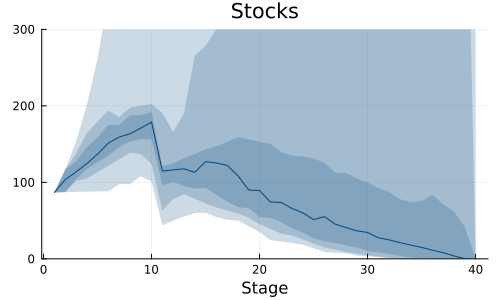

In [187]:
import Plots

Plots.plot(
    SDDP.publication_plot(simulations, title = "Stocks") do data
        return data[:stocks].out
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 300),
    layout = (1, 2),
)

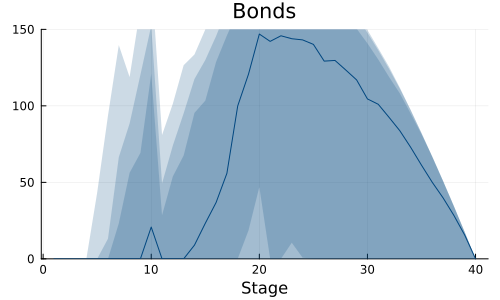

In [188]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Bonds") do data
        return data[:bonds].out
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 150),
    layout = (1, 2),
)

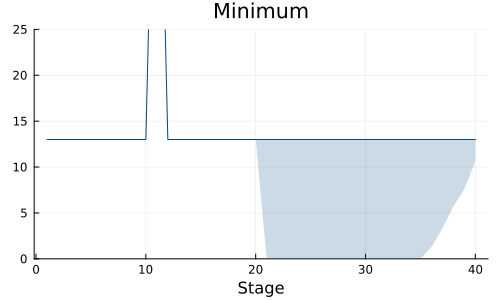

In [189]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Minimum") do data
        return data[:minimum]
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 25),
    layout = (1, 2),
)

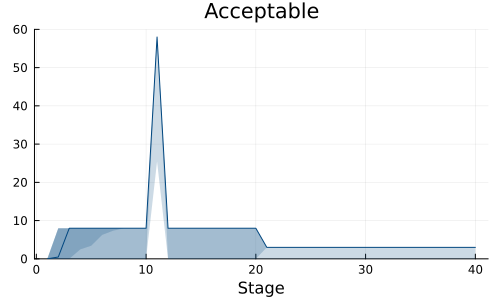

In [190]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Acceptable") do data
        return data[:acceptable]
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 60),
    layout = (1, 2),
)

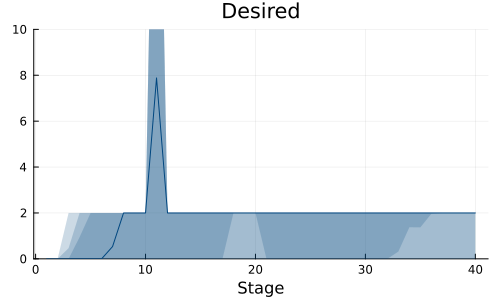

In [191]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Desired") do data
        return data[:desired]
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 10),
    layout = (1, 2),
)

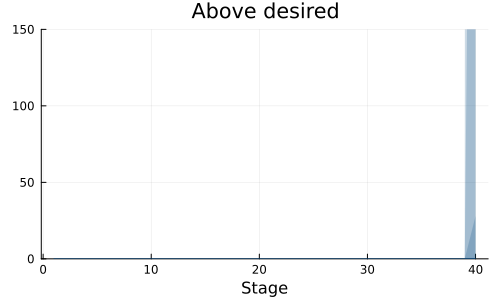

In [192]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Above desired") do data
        return data[:above_desired]
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 150),
    layout = (1, 2),
)

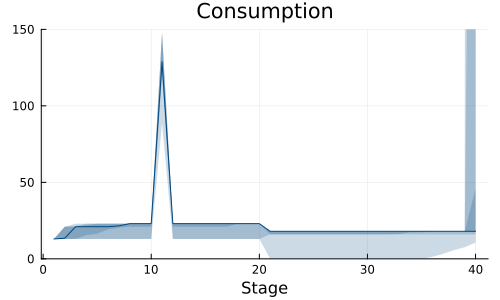

In [193]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Consumption") do data
        return data[:consumption]
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 150),
    layout = (1, 2),
)

In [215]:
n_scenarios = 1500
n_stages = 40
bonds = zeros(n_scenarios,n_stages)
stocks = zeros(n_scenarios,n_stages)
consumption = zeros(n_scenarios,n_stages)

for (i, scenario) in enumerate(simulations)
    bonds[i,:] = [node[:bonds].out for node in scenario]
    stocks[i,:] = [node[:stocks].out for node in scenario]
    consumption[i,:] = [node[:consumption] for node in scenario]
end

bonds_perc = zeros(5,n_stages)

for t in 1:n_stages
    bonds_perc[:,t] = quantile(bonds[:,t], [0.05, 0.25, 0.5, 0.75, 0.95])
end

stocks_perc = zeros(5,n_stages)

for t in 1:n_stages
    stocks_perc[:,t] = quantile(stocks[:,t], [0.05, 0.25, 0.5, 0.75, 0.95])
end

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,86.7484,87.1762,87.5471,94.4576,101.783,109.034,118.775,124.753,134.386,142.251,90.7394,90.6364,98.8146,107.484,115.845,123.129,132.676,141.452,152.282,165.572,150.293,144.918,137.55,128.434,119.865,117.078,110.881,103.981,98.4968,90.4441,85.428,79.8908,75.274,67.2309,56.6606,46.9376,35.8371,24.4955,12.3005,0.0
2,86.7484,87.1762,101.372,109.402,117.083,128.096,135.676,147.723,155.458,170.791,90.7394,108.361,121.544,132.151,147.416,162.155,175.056,189.698,206.889,219.609,216.068,212.716,206.167,197.849,188.88,182.369,174.031,164.16,153.601,142.725,130.85,118.09,106.114,92.4591,78.4944,64.3273,49.3294,33.5426,17.4203,0.0
3,86.7484,95.9418,105.687,116.016,133.5,150.642,163.429,178.787,195.863,212.309,132.429,144.738,158.684,169.343,186.087,200.308,212.636,225.025,235.503,248.574,243.965,235.154,227.281,218.771,209.57,198.868,187.621,176.876,164.68,152.083,139.292,125.668,111.802,97.2274,82.1964,66.7143,50.7678,34.3429,17.4252,0.0
4,86.7484,116.501,127.48,138.125,151.516,166.669,202.535,221.47,238.91,259.605,156.013,178.017,188.839,200.434,210.553,222.358,233.617,243.931,256.15,266.185,257.028,247.826,238.438,228.359,217.432,205.066,193.227,181.12,168.057,154.642,140.951,127.311,113.035,98.1486,82.8757,66.8383,50.7803,34.3435,17.4252,0.0
5,86.7484,116.501,153.096,168.561,182.368,228.364,245.847,262.801,286.372,313.549,205.213,221.571,232.849,257.423,279.642,294.578,326.667,347.421,371.594,393.177,411.138,431.44,439.438,451.631,489.821,475.936,497.982,522.481,522.601,527.606,585.228,555.769,570.758,642.261,678.329,701.412,709.051,717.689,710.844,0.0


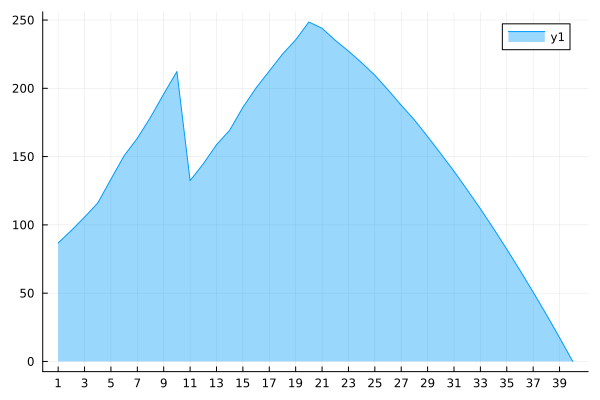

In [216]:
wealth = stocks .+ bonds

wealth_perc = zeros(5,n_stages)

for t in 1:n_stages
    wealth_perc[:,t] = quantile(wealth[:,t], [0.05, 0.25, 0.5, 0.75, 0.95])
end


display(DataFrame(wealth_perc, :auto))

areaplot(wealth_perc[3,:], fillalpha=0.4, xticks=1:2:n_stages)


Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,1.0,1.0,0.950055,0.869019,0.611055,0.53832,0.445468,0.440579,0.28851,0.440768,0.380759,0.290452,0.253065,0.224666,0.201681,0.176668,0.138162,0.125285,0.102902,0.0889774,0.0741568,0.0661191,0.0535764,0.045552,0.0366363,0.0299408,0.0223279,0.0167194,0.0103944,0.00473124,0.00064688,2.70725e-6,6.07216e-13,-3.2133e-12,-1.90915e-11,-5.95678e-11,-9.22234e-11,-9.04915e-11,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,0.802703,0.725639,0.631704,0.578362,0.523932,0.478089,0.432559,0.376573,0.297454,0.262444,0.22445,0.200475,0.178571,0.152797,0.134555,0.121524,0.102712,0.103609,0.0804894,0.0782176,0.064601,0.0516487,0.0399528,0.033566,0.0255809,0.0209396,0.0152685,0.00283816,3.29728e-5,2.49371e-10,9.51771e-12,3.97473e-13,3.68031e-13,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.974806,0.704889,1.0,0.925412,0.710366,0.704902,0.568273,0.480905,0.427994,0.338245,0.32208,0.302982,0.26954,0.253966,0.228335,0.23404,0.225456,0.201075,0.203044,0.189738,0.175363,0.176225,0.156661,0.146049,0.150978,0.133523,0.115579,0.0854357,0.064449,0.00187351,2.31223e-8,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.989229,0.790279,0.596928,0.575141,0.637418,0.550775,0.60845,0.67518,0.673457,0.718092,0.591674,0.693912,0.719728,0.708962,0.733742,0.735419,0.755724,0.831053,0.812781,1.0,0.948793,1.0,0.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


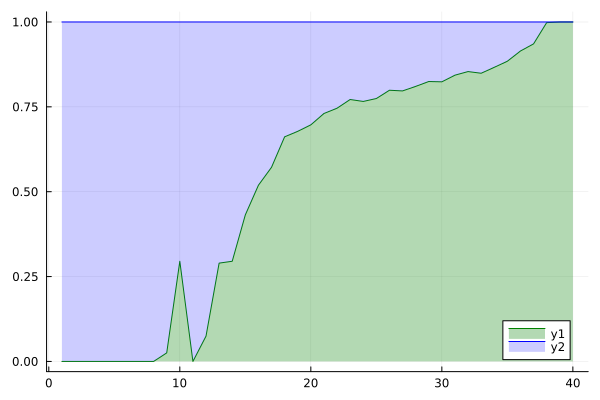

In [217]:
stocks_weight = stocks ./wealth

stocks_weight[:,end] .= 0

stocks_weight_perc = zeros(5,n_stages)

for t in 1:n_stages
    stocks_weight_perc[:,t] = quantile(stocks_weight[:,t], [0.05, 0.25, 0.5, 0.75, 0.95])
end

display(DataFrame(stocks_weight_perc, :auto))

bonds_weight_perc = 1 .- stocks_weight_perc

areaplot(1:n_stages, [bonds_weight_perc[3,1:n_stages] stocks_weight_perc[3,1:n_stages]], seriescolor = [:green :blue], fillalpha = [0.3 0.2], zticks=1:1:n_stages)

In [218]:
consumption_perc = zeros(5,n_stages)

for t in 1:n_stages
    consumption_perc[:,t] = quantile(consumption[:,t], [0.05, 0.25, 0.5, 0.75, 0.95])
end

DataFrame(consumption_perc, :auto) 

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,73.3555,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,15.0283,13.0,13.0,13.0,12.53,13.0,13.0,13.0,13.0,13.0,13.0,13.0,16.0,16.0,15.9899,16.0,16.0,16.0,15.7421,15.9066
2,13.0,13.0,16.0089,16.4287,18.9511,21.0,21.0,21.0,21.0,21.0,118.036,21.0,21.0,21.0,23.0,23.0,23.0,23.0,23.0,23.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,17.9627,17.9804,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
3,13.0,21.0,21.0,21.0,21.0,21.0,23.0,23.0,23.0,23.0,121.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
4,13.0,21.0,21.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,146.414,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
5,13.0,21.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,148.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,809.586


In [220]:
minimum_limit = model_data.minimum_limit
acceptable_limit = model_data.acceptable_limit
desired_limit = model_data.desired_limit
limits = [minimum_limit, acceptable_limit, desired_limit]

goals_succes = zeros(n_stages,3)

for goal in 1:3
    goals_succes[:,goal] = [count(c -> (round(c,digits=1) >= limits[goal][t]), consumption[:,t]) /n_scenarios for t in 1:n_stages]
end

DataFrame(goals_succes, ["above minimum","above acceptable","above_desired"])

Row,above minimum,above acceptable,above_desired
,Float64,Float64,Float64
1,1.0,0.0,0.0
2,1.0,0.742,0.0
3,1.0,0.688,0.0853333
4,1.0,0.720667,0.324667
5,1.0,0.748667,0.431333
6,1.0,0.790667,0.474
7,1.0,0.808667,0.536667
8,1.0,0.818667,0.546
9,1.0,0.823333,0.594


In [221]:
total_consumption = sum(consumption,dims=2)

total_consumption_perc = [quantile(total_consumption,[0.05, 0.25, 0.5, 0.75, 0.95])]


1-element Vector{Vector{Float64}}:
 [707.0561046641213, 813.0964214459042, 875.9708856867453, 921.0139463108818, 1709.5101541435824]

# Need Help?

* Learning: https://julialang.org/learning/
* Documentation: https://docs.julialang.org/
* Questions & Discussions:
  * https://discourse.julialang.org/
  * http://julialang.slack.com/
  * https://stackoverflow.com/questions/tagged/julia

If you ever ask for help or file an issue about Julia, you should generally provide the output of `versioninfo()`.

Add new code cells by clicking the `+ Code` button (or _Insert_ > _Code cell_).

Have fun!

<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-mask.png" height="100" />